# Project 2
### CS 5/7394 - Applied Machine Learning

- **Due** - March 11 @ 11:59 pm pushed to Github repo
- **Teams** - You can do this project solo or in pairs.  Not 3, not 4 not 5... Max of 2. If a 5394 student pairs with a 7394 student, the pair needs to do the 7394 work. 

Below are 6 Kaggle Datasets.  You will choose 1 to work with for this project. 

- [Airfare Prediction Dataset](https://www.kaggle.com/zwartfreak/airline-fare-prediction)
- [Chinese Rest Holiday Dataset](https://www.kaggle.com/holoong9291/chinese-rest-holiday-dataset-2020-to-2022)
- [Jigsaw Toxic Comment Classification Challenge](https://www.kaggle.com/julian3833/jigsaw-toxic-comment-classification-challenge?select=train.csv)
- [Latest Covid 19 Dataset Worldwide](https://www.kaggle.com/sandhyakrishnan02/latest-covid-19-dataset-worldwide)
- [Trains](https://www.kaggle.com/vahidehdashti/machinelearningdatabase-trains?select=trains-original.data)
- [Football Data top 5 Leagues](https://www.kaggle.com/sanjeetsinghnaik/football-data-top-5-leagues)

Merging disparate datasets is a staple of the data exploration process.  Therefore, for which ever data set above that you choose, you will need to independently find **an additional** dataset to merge with your selection.  The only requirement is that it add to the richness of the original dataset. Students in the 7000-level version of the class need to find two additional data sets to merge with the original selection. 

_Note_: If you want to start with a different data set, you need to get Fontenot's OK first.  

### Your Tasks

Below, there are cells that provide directions on what to do for the project.  

You can insert as many cells between the ones below as you'd like, but please **Do NOT** change the cells already provided. 

### Part 1 - Getting Started

- Import libraries
- Load original Data (which ever one you chose from the provided list) into a data frame. 
- Load your additional data set(s) into a data frame. 
- In a markdown cell, provide a brief description of your the data sets you've chosen to work with.  
- Develop a list of 3 - 4 questions that you hope to be able to answer after the exploration of the data and write them in this section. 

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

import scipy.stats as stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

import matplotlib.pyplot as plt
import seaborn as sn

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

sn.set_style('whitegrid')
sn.set_context('talk')

plt.rcParams.update(params)
pd.options.display.max_colwidth = 600

### Airline Data Set
The data set we've chosen to use an index of domestic Indian airline flights that took place in 2019. The primary purpose of the dataset is to track the fluctation of the price of airfare and intened to be used to predict the price of an airline ticket given specific data about the the flight

### Holiday Data Set
This data set contains every holiday celebrated in India in 2019. One of the most notable features of it is that it contains whether or not the holiday is concidered "Restricted" or "Gazetted" by the Indian government. Restricted means that a holiday isn't recognized by the government as an offical holiday, where if a holiday is gazetted, it means the government has mandated that holiday.


**NOTE** For all datasets, the prices are in rupees (or INR). 
For context **1 INR = 0.013 USD**  and  **1 USD = 76.49 INR**

### Exploration Questions

- How much do upcoming/recent holidays affect airline prices?
- Do restricted holidays affect airline prices more than gazetted holidays?
- How does the amount of days to the nearest holiday (gatetted/restricted) affect the price of the flight?

### Read and Clean Datasets 

In [2]:
airfare = pd.read_csv('airfareTrain.csv')
holidays = pd.read_csv('holidays2019.csv')

#Standardiszing Attribute Names
airfare.rename(columns={'Airline':'airline',
                            'Date_of_Journey':'date',
                            'Source':'starting_city',
                            'Destination':'destination',
                            'Route':'route',
                            'Dep_Time':'depart_time',
                            'Arrival_Time':'arrival_time',
                            'Duration':'duration',
                            'Total_Stops':'total_stops',
                            'Additional Info':'misc',
                            'Price':'price'},inplace=True)

airfare = airfare.drop(['route', 'arrival_time','misc'], axis=1)

airfare['total_stops'].replace(['non-stop', '1 stop', '2 stops', '3 stops', '4 stops', '5 stops'], [0, 1, 2, 3, 4, 5], inplace=True)

#Typecasting Attributes
    #AirFare
airfare['date']     = pd.to_datetime(airfare.date)
airfare['duration'] = pd.to_timedelta(airfare.duration).astype('timedelta64[m]')
airfare['duration'] = pd.to_numeric(airfare.duration)
airfare['price']    = pd.to_numeric(airfare.price)
airfare['depart_time'] = pd.to_datetime(airfare.depart_time).dt.hour

airfare['airline'] = airfare.airline.astype('category')
airfare['starting_city'] = airfare.starting_city.astype('category')
airfare['destination'] = airfare.destination.astype('category')

    
    #Holidays
holidays = holidays.drop(['day'], axis=1)	
holidays['date']    = pd.to_datetime(holidays.date)
holidays['holiday_type'].replace(['Restricted','Gazetted'], [0, 1], inplace=True)


### Part 2 - Data Inspection

Write some code to summarize the datasets.  Think about the following questions:
- What type of data is each variable? (think like a data scientist here, not a computer scientist)
- What is the total size of the data sets?
- What time boundaries are there in the dataset?  IOW, what time frame do they span?
- Are there any missing values in any of the variables? 

Do this with Intentionality.  Don't skimp. 

### What type of data is each variable?

In [3]:
print("=Airfare Types=\n",airfare.dtypes,"\n")
print("=Holiday Types=\n",holidays.dtypes)

=Airfare Types=
 airline                category
date             datetime64[ns]
starting_city          category
destination            category
depart_time               int64
duration                float64
total_stops             float64
price                     int64
dtype: object 

=Holiday Types=
 date            datetime64[ns]
holiday                 object
holiday_type             int64
dtype: object


### What is the total size of the data sets?

In [4]:
print("Shape of Airfare:  ", airfare.shape, '\t\tTotal Size: ', airfare.size)
print("Shape of Holidays: ",holidays.shape, '\t\tTotal Size: ', holidays.size)

Shape of Airfare:   (10683, 8) 		Total Size:  85464
Shape of Holidays:  (46, 3) 		Total Size:  138


### What time boundaries are there in the dataset?  IOW, what time frame do they span?

In [5]:
print("Airfare start date: ",airfare['date'].min())
print("Airfare end date:   ",airfare['date'].max(),'\n')
print(pd.date_range(start=airfare['date'].min(), end=airfare['date'].max()))

print("\nHoliday start date: ",holidays['date'].min())
print("Holiday end date:   ",holidays['date'].max(),'\n')
print(pd.date_range(start=holidays['date'].min(), end=holidays['date'].max()))

Airfare start date:  2019-01-03 00:00:00
Airfare end date:    2019-12-06 00:00:00 

DatetimeIndex(['2019-01-03', '2019-01-04', '2019-01-05', '2019-01-06',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-12',
               ...
               '2019-11-27', '2019-11-28', '2019-11-29', '2019-11-30',
               '2019-12-01', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06'],
              dtype='datetime64[ns]', length=338, freq='D')

Holiday start date:  2019-01-01 00:00:00
Holiday end date:    2019-12-25 00:00:00 

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-21', '2019-12-22', '2019-12-23',
               '2019-12-24', '2019-

### Are there any missing values in any of the variables? 

In [6]:
print("=Airline Values=\n")

print(
    "airline:\t\t",           airfare.airline.isnull().values.any(),
    "\ndate:\t\t\t",          airfare.date.isnull().values.any(),
    "\nstarting_city:\t\t",   airfare.starting_city.isnull().values.any(),
    "\ndestination:\t\t",     airfare.destination.isnull().values.any(),
    "\nduration:\t\t",        airfare.duration.isnull().values.any(),
    "\ndepart_time:\t\t",     airfare.depart_time.isnull().values.any(),
    "\ntotal_stops:\t\t",     airfare.total_stops.isnull().values.any(), airfare.total_stops.isnull().values.sum()
)

print("\n=Holday Values=\n")
print(
    "date:\t\t\t",            holidays.date.isnull().values.any(),
    "\nholiday:\t\t",       holidays.holiday.isnull().values.any(),
    "\nholiday_type:\t\t",  holidays.holiday_type.isnull().values.any()

)

=Airline Values=

airline:		 False 
date:			 False 
starting_city:		 False 
destination:		 False 
duration:		 False 
depart_time:		 False 
total_stops:		 True 1

=Holday Values=

date:			 False 
holiday:		 False 
holiday_type:		 False


#### We noticed that there is one value of total_stops that is N/A
 Through running the code below we were able to find it which exact index was missing, in our case it was one empty cell, then fill it with an assumed zero

In [7]:
print("Index of N/A value:",airfare['total_stops'].index[airfare['total_stops'].apply(np.isnan)].get_value)
airfare["total_stops"] = airfare["total_stops"].fillna(0)
print("total_stops:\t",     airfare.total_stops.isnull().values.any())

Index of N/A value: <bound method Index.get_value of Int64Index([9039], dtype='int64')>
total_stops:	 False


### Part 3 - Data Description

- Create a data description (data dictionary) for your data sets.
    - Describe each variable
    - If categorical, what levels are present? If the levels are encoded, what do the codes mean?
    - If numeric, provide min, max, median and any other univariate stats you'd like to add in. 
- Where appropriate, provide histograms or other visualizations to characterize each variable. 

## Airline Fare Data Dictionarty

- airline        : Name of airline carrier (Air India, IndiGo, Multiple Carriers, etc.)           
- starting_city  : Starting city (Delhi, Kolkata, Banglore, etc)                         
- destination    : Destination city (Delhi, Kolkata, Banglore, etc.)               
- date           : Data         
- duration       : Total duration of the flight in minutes
- total_stops    : Total amount of layovers in the route
- pirce          : Price of the flight in rupees


In [8]:
airfare.dtypes

airline                category
date             datetime64[ns]
starting_city          category
destination            category
depart_time               int64
duration                float64
total_stops             float64
price                     int64
dtype: object

In [9]:
print('=Airline values=\n',airfare['airline'].cat.categories.tolist())
print('\n=starting_city values=\n',airfare['starting_city'].cat.categories.tolist())
print('\n=destination values=\n',airfare['destination'].cat.categories.tolist())

=Airline values=
 ['Air Asia', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways', 'Jet Airways Business', 'Multiple carriers', 'Multiple carriers Premium economy', 'SpiceJet', 'Trujet', 'Vistara', 'Vistara Premium economy']

=starting_city values=
 ['Banglore', 'Chennai', 'Delhi', 'Kolkata', 'Mumbai']

=destination values=
 ['Banglore', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata', 'New Delhi']


In [10]:
print("=Date=\nmin: ", airfare['date'].min() ,'\nmax:', airfare['date'].max(), '\nmedian: ')
print("\n=Duration=\nmin: ", airfare['duration'].min() ,'\nmax:', airfare['duration'].max(), '\nmedian: ', airfare['duration'].median())
print("\n=Price=\nmin: ", airfare['price'].min() ,'\nmax:', airfare['price'].max(), '\nmedian: ', airfare['price'].median())

=Date=
min:  2019-01-03 00:00:00 
max: 2019-12-06 00:00:00 
median: 

=Duration=
min:  5.0 
max: 2860.0 
median:  520.0

=Price=
min:  1760 
max: 79513 
median:  8373.0


<AxesSubplot:>

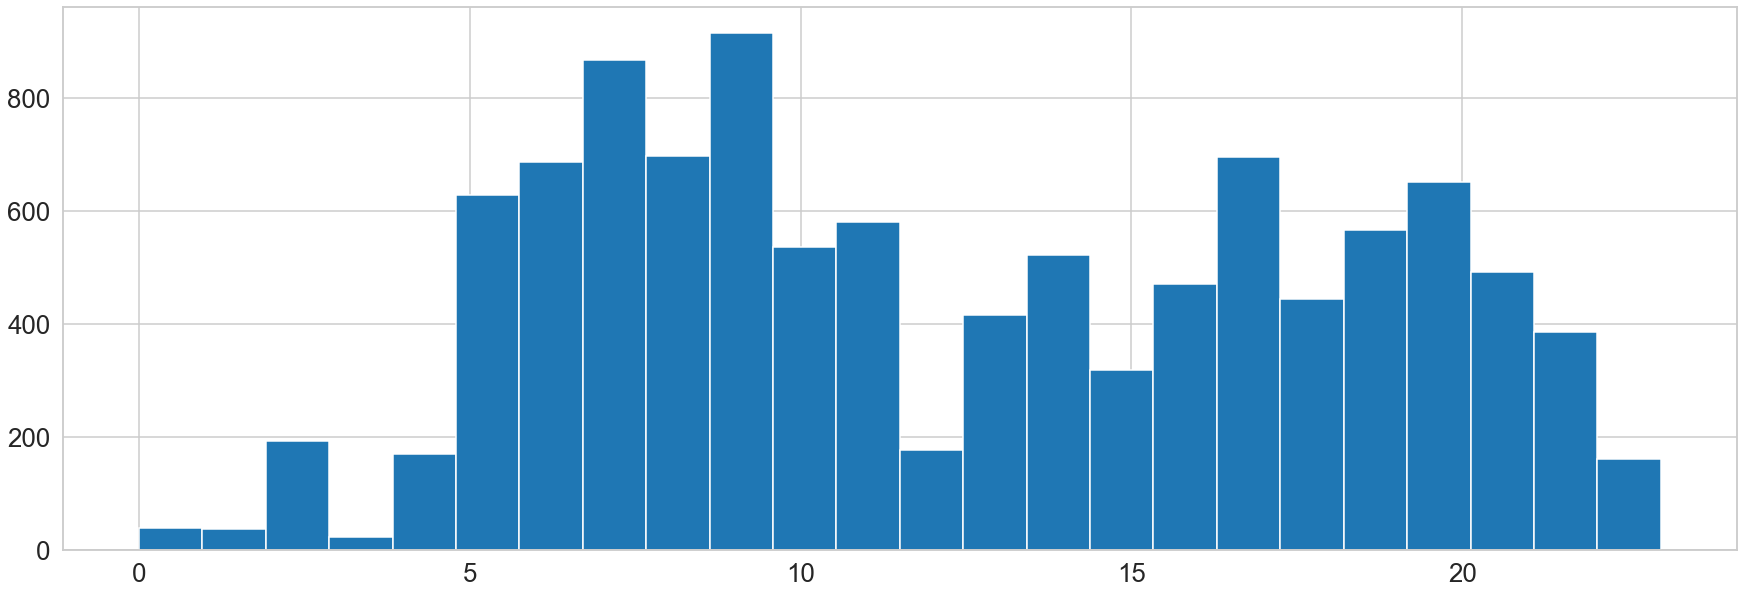

In [11]:
airfare['depart_time'].hist(bins=24)

<AxesSubplot:>

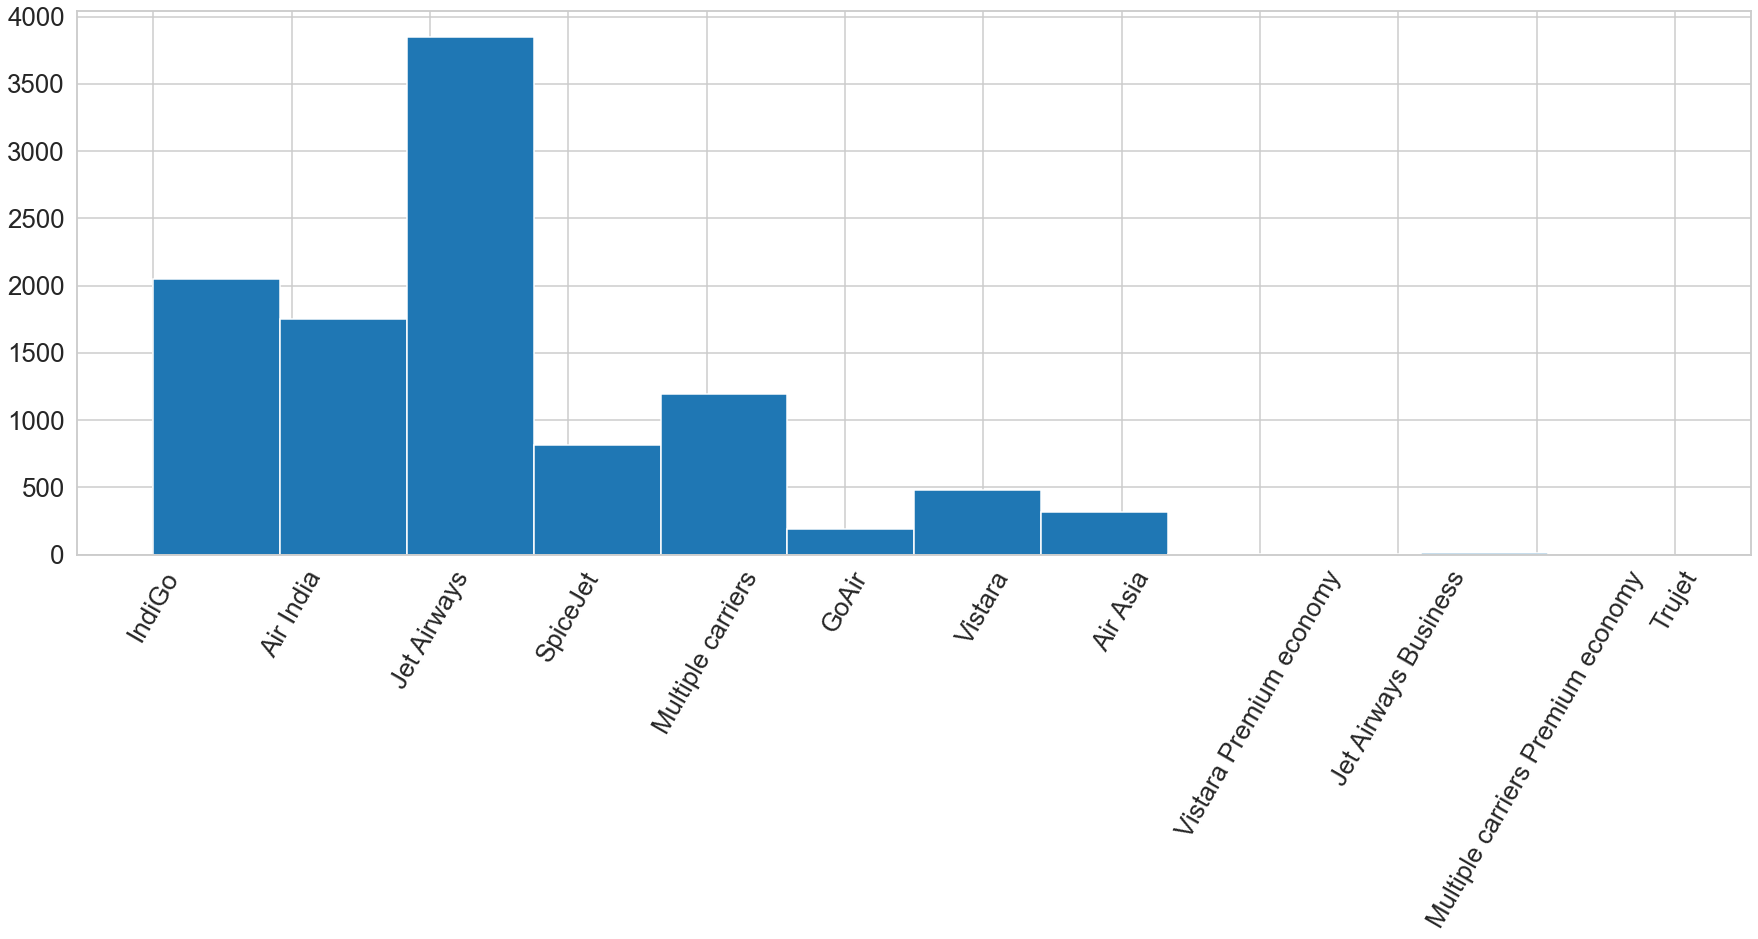

In [12]:
plt.xticks(rotation=60)

airfare['airline'].hist(bins=12)

<AxesSubplot:xlabel='month', ylabel='Count'>

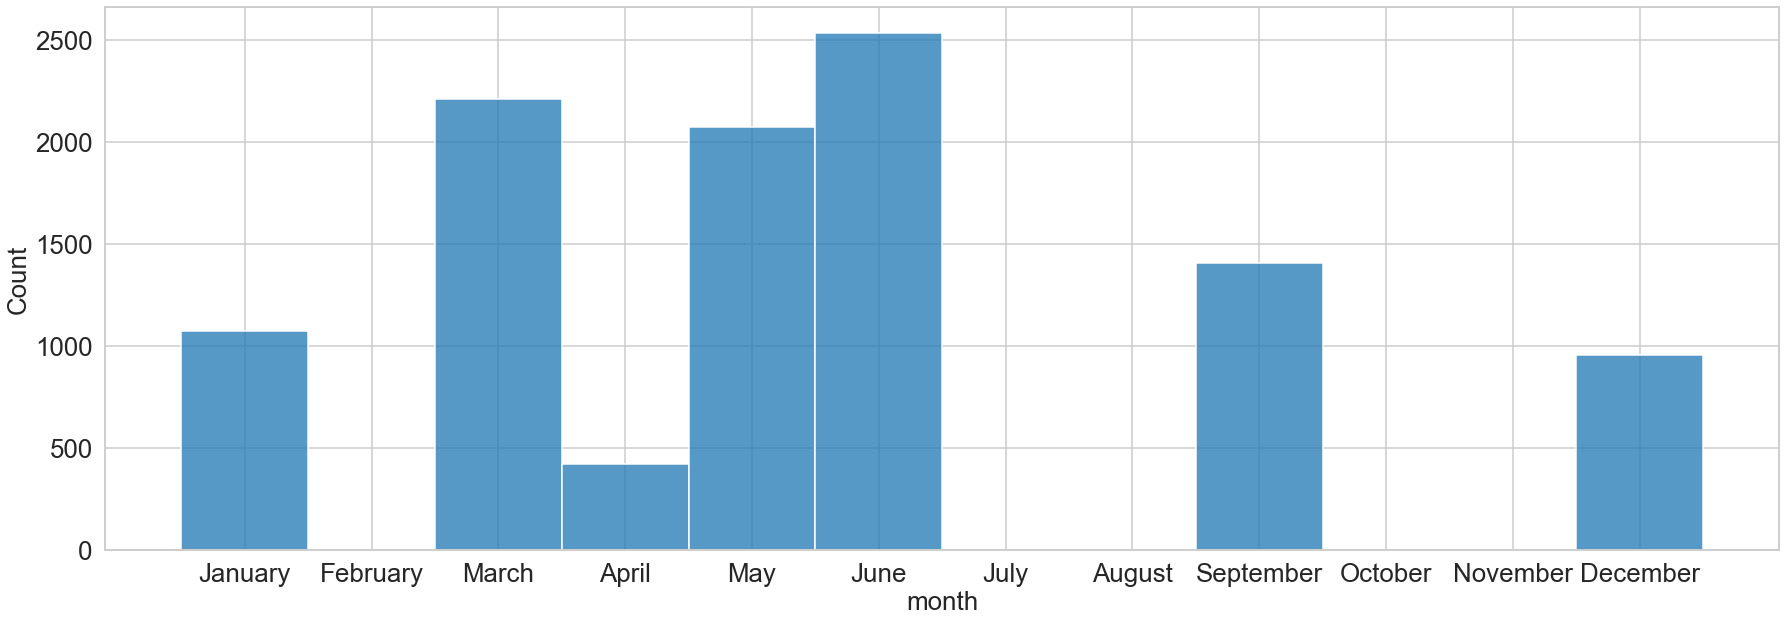

In [13]:
airfare['month'] = airfare['date'].dt.month_name()
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
airfare['month'] = pd.Categorical(airfare['month'], categories=months, ordered=True)
sn.histplot(x=airfare['month'])

<AxesSubplot:xlabel='day_of_week', ylabel='Count'>

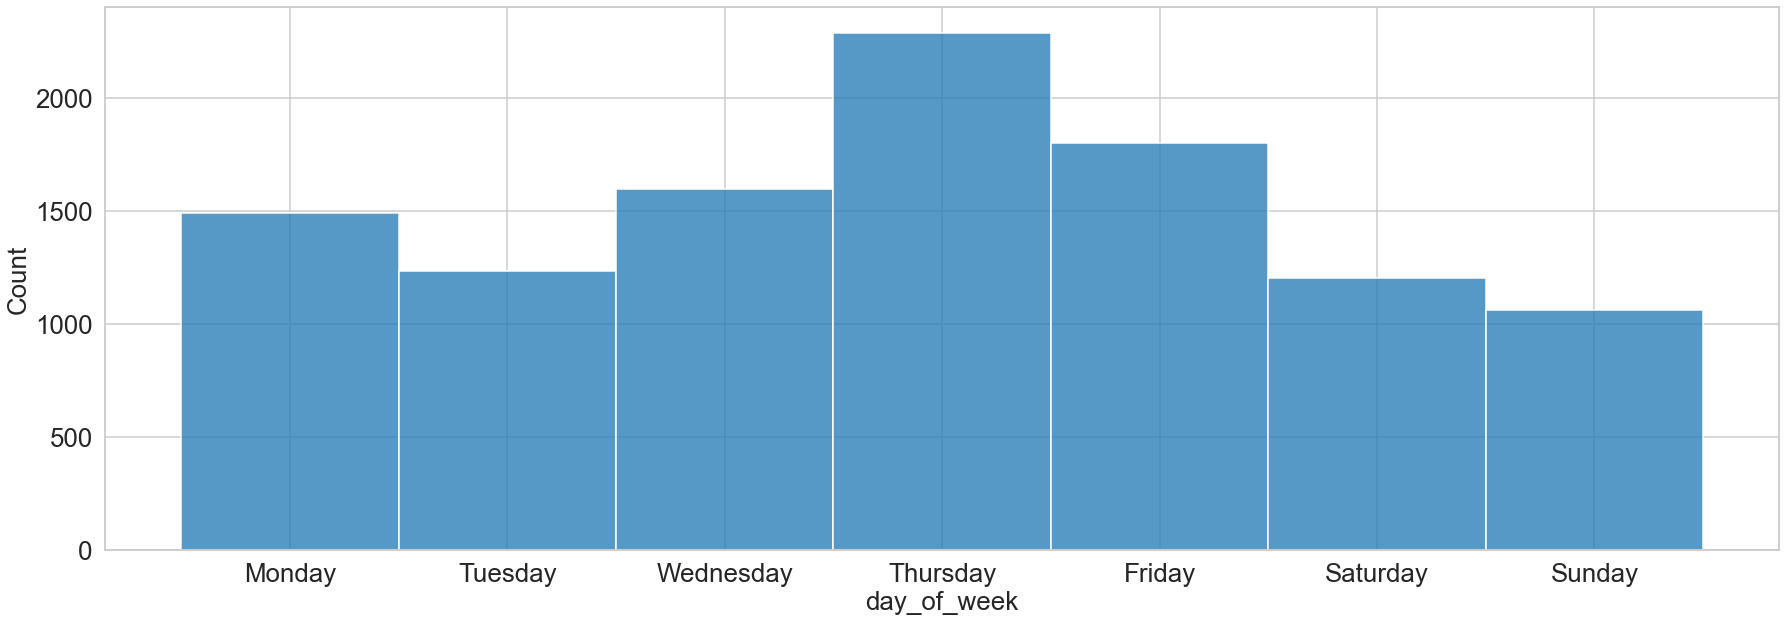

In [14]:
airfare['day_of_week'] = airfare['date'].dt.day_name()
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
airfare['day_of_week'] = pd.Categorical(airfare['day_of_week'], categories=days, ordered=True)
sn.histplot(x=airfare['day_of_week'])

<AxesSubplot:>

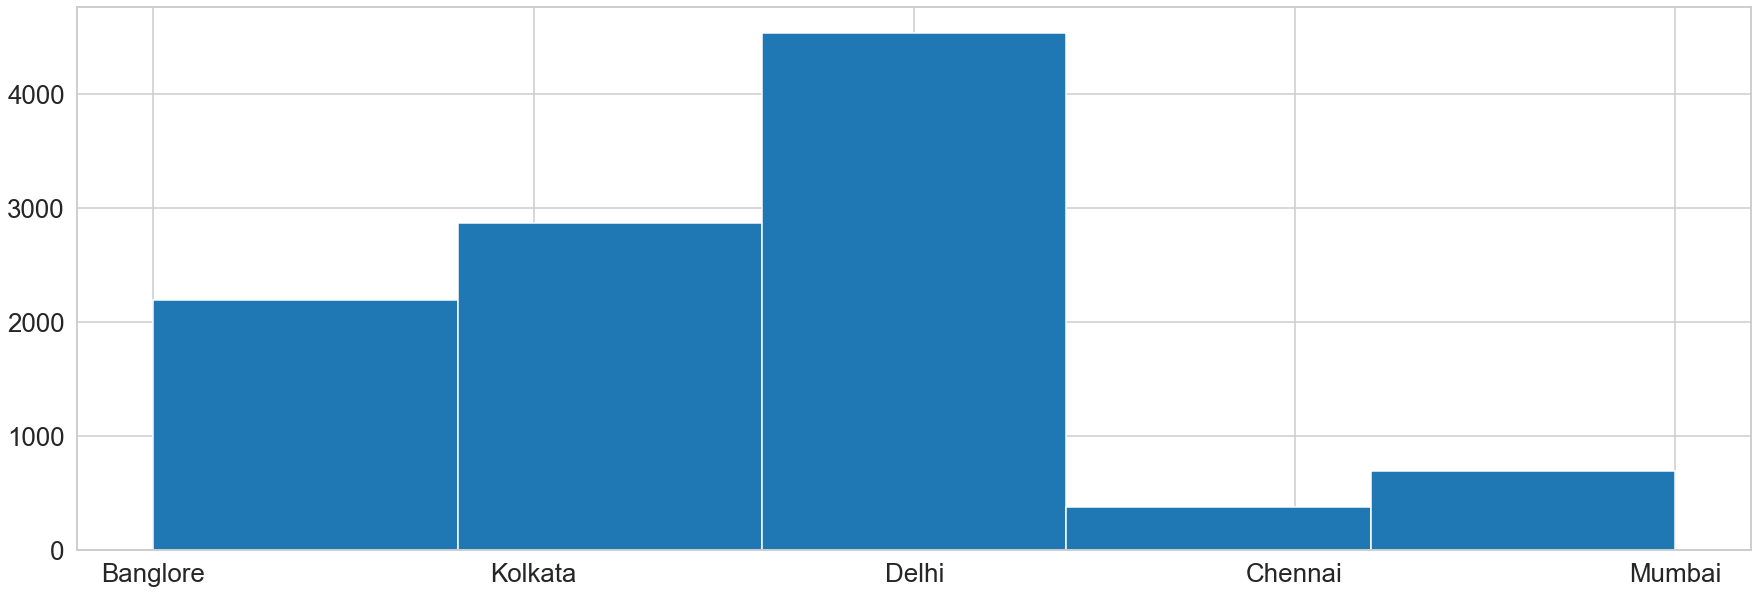

In [15]:
airfare['starting_city'].hist(bins=5)

<AxesSubplot:>

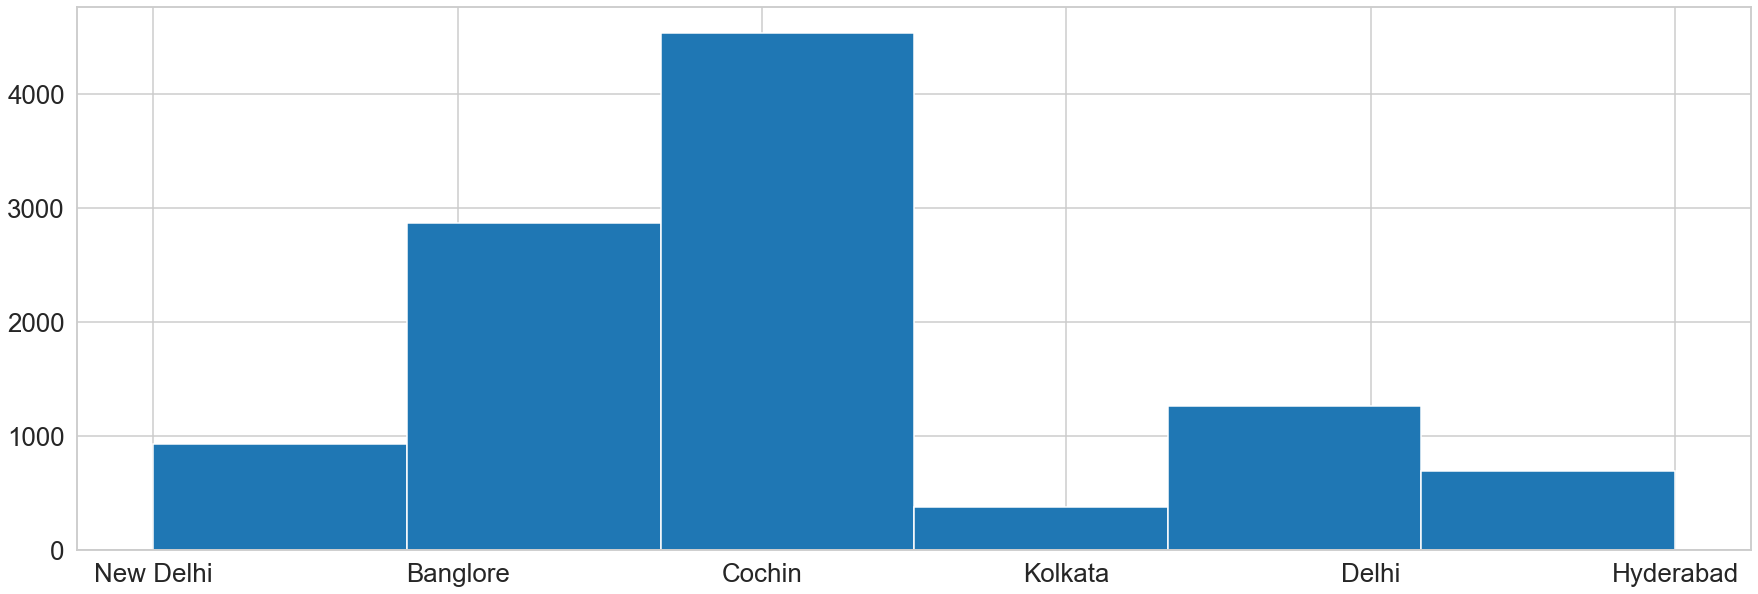

In [16]:
airfare['destination'].hist(bins=6)

<AxesSubplot:>

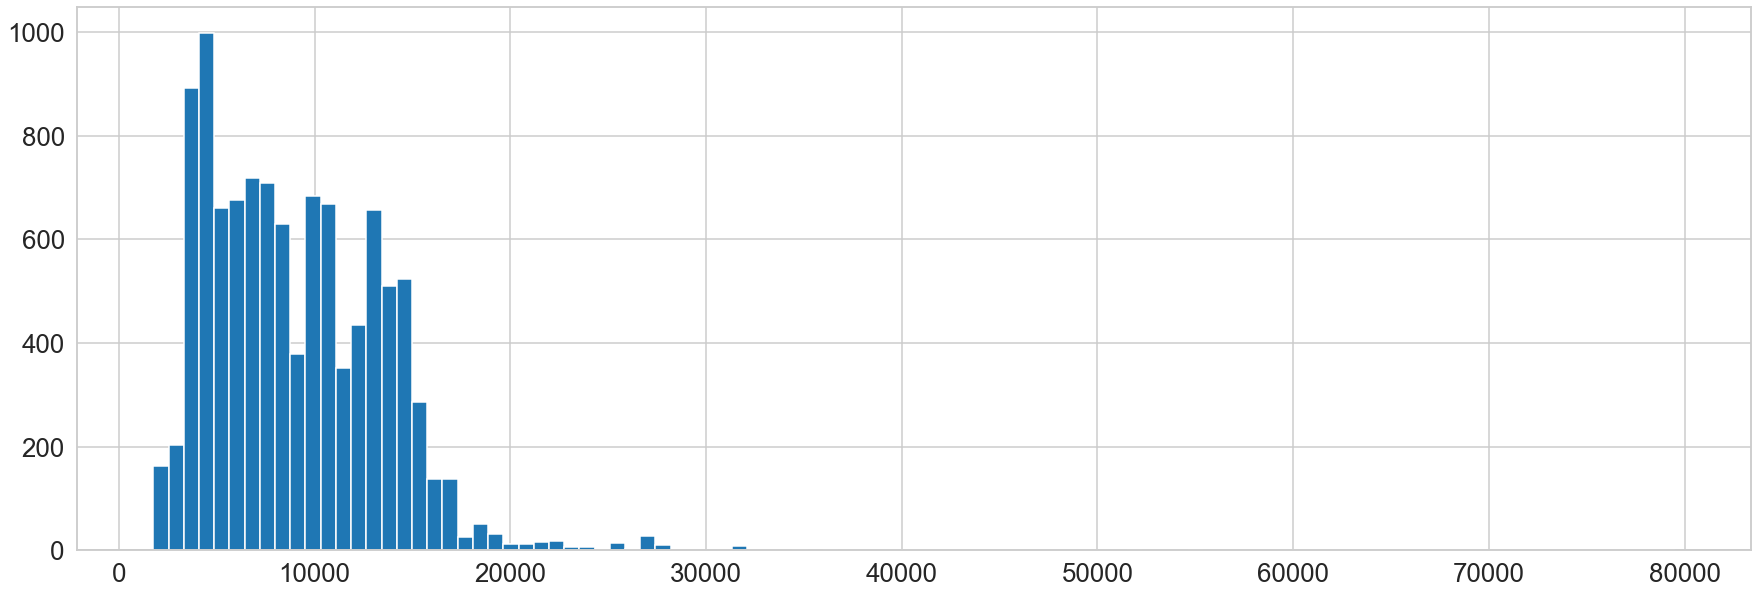

In [17]:
airfare['price'].hist(bins=100)

<AxesSubplot:>

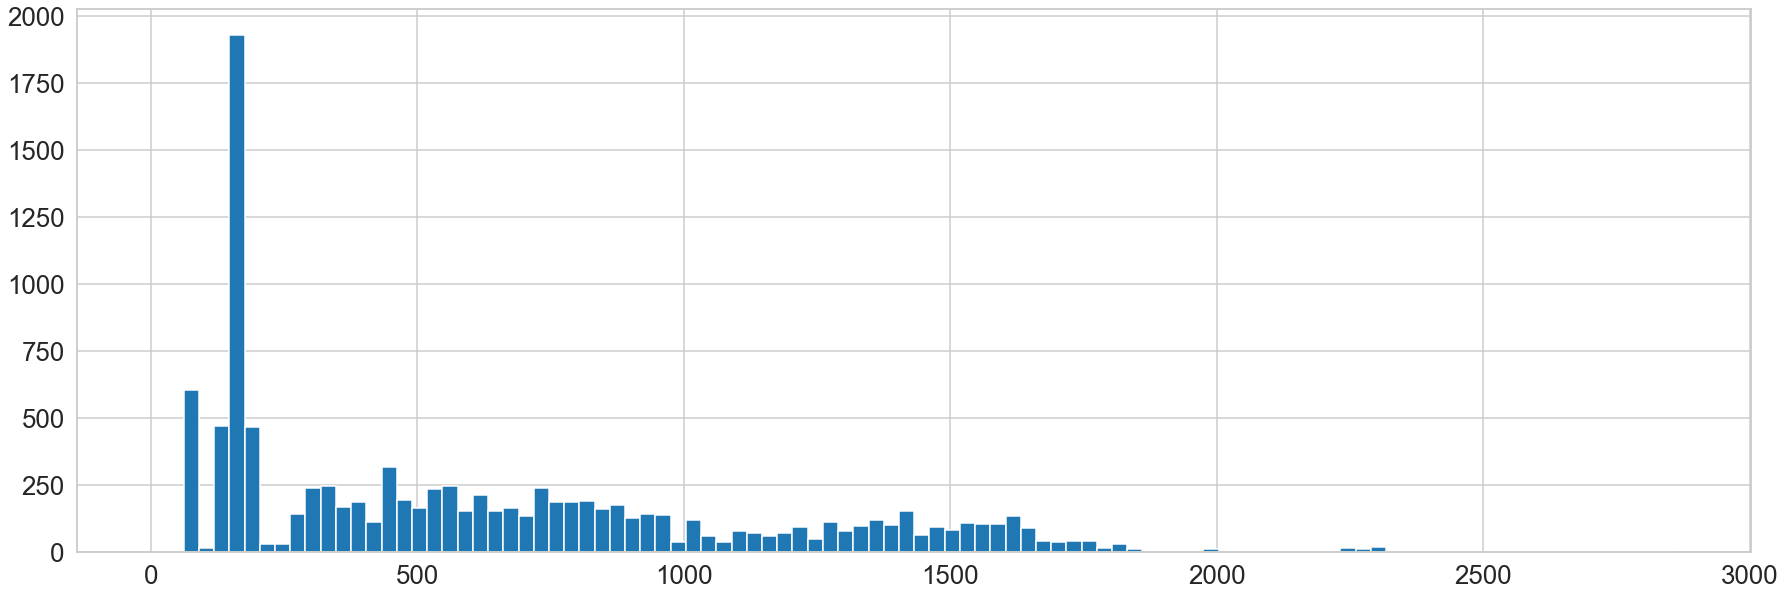

In [18]:
airfare['duration'].hist(bins=100)

## Holiday Data Dictionarty

- date           : date of holiday
- holiday        : name of the holiday
- holiday_type   : Whether or not it is concidered "Restricted" or "Gazetted"
                   0 = Restricted (Not Nationally Recognized)
                   1 = Gazetted   (Nationally Recognized)
                   

In [19]:
holidays.dtypes

date            datetime64[ns]
holiday                 object
holiday_type             int64
dtype: object

In [20]:
print("=Date=\nmin: ", holidays['date'].min() ,'\nmax:', holidays['date'].max())

=Date=
min:  2019-01-01 00:00:00 
max: 2019-12-25 00:00:00


<AxesSubplot:xlabel='month', ylabel='Count'>

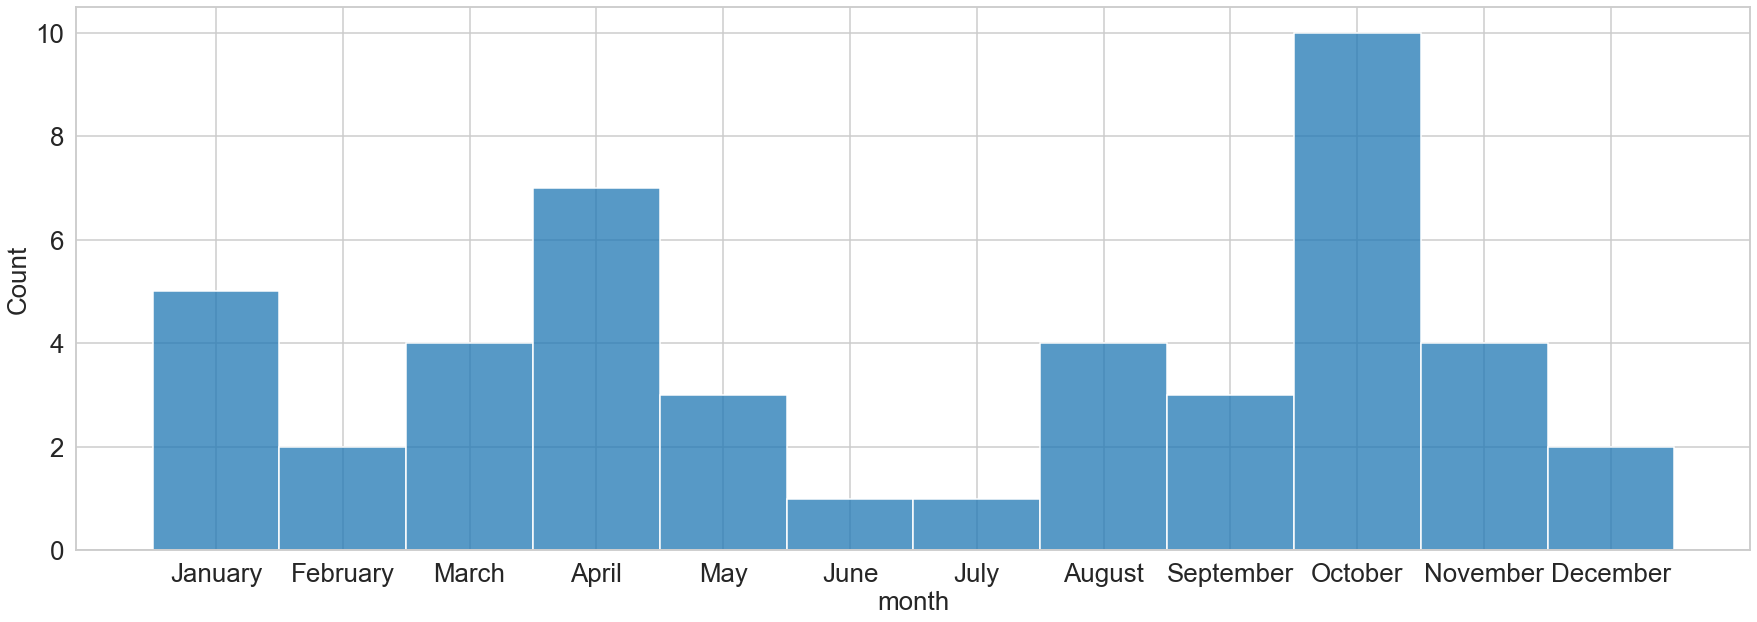

In [21]:
holidays['month'] = holidays['date'].dt.month_name()
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
holidays['month'] = pd.Categorical(holidays['month'], categories=months, ordered=True)
sn.histplot(x=holidays['month'])

<AxesSubplot:xlabel='day_of_week', ylabel='Count'>

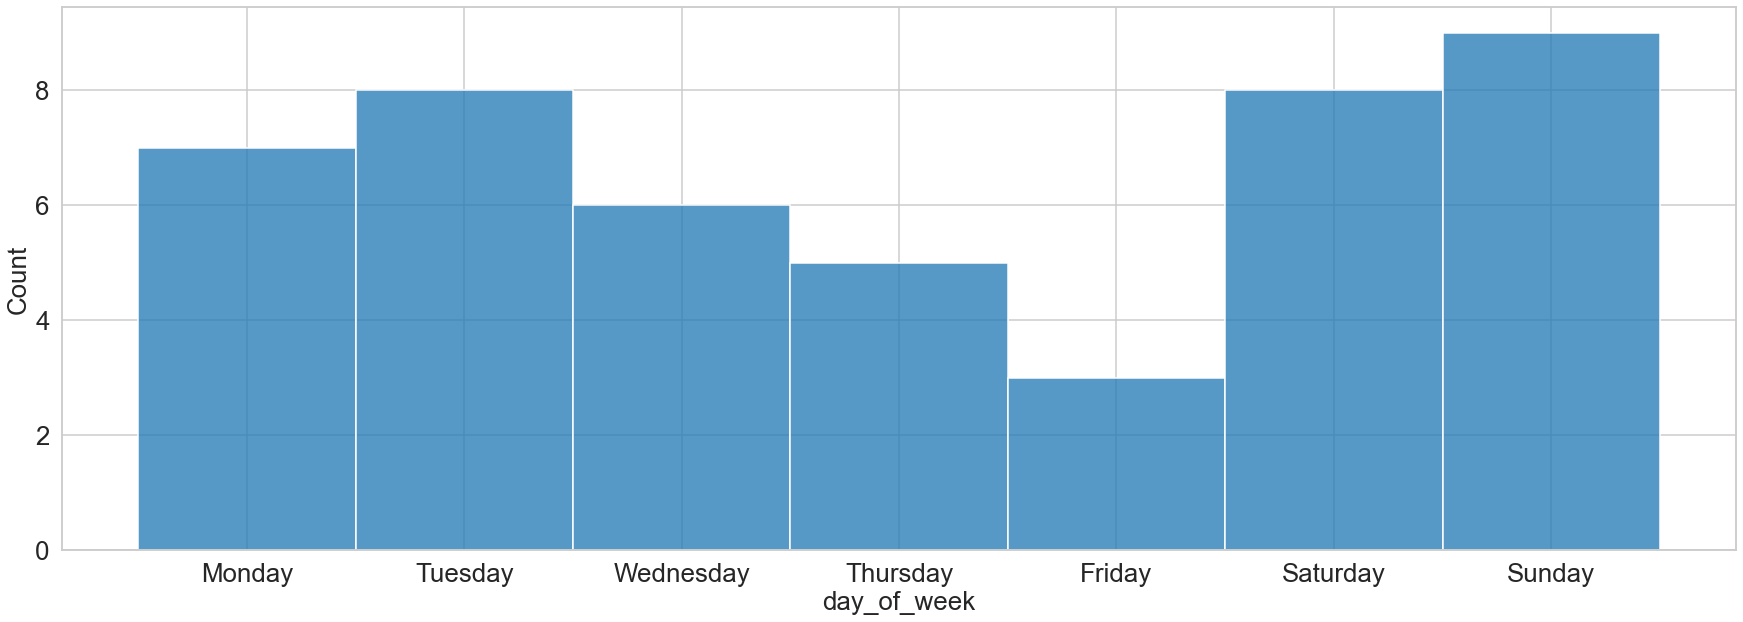

In [22]:
holidays['day_of_week'] = holidays['date'].dt.day_name()
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
holidays['day_of_week'] = pd.Categorical(holidays['day_of_week'], categories=days, ordered=True)
sn.histplot(x=holidays['day_of_week'])

<AxesSubplot:>

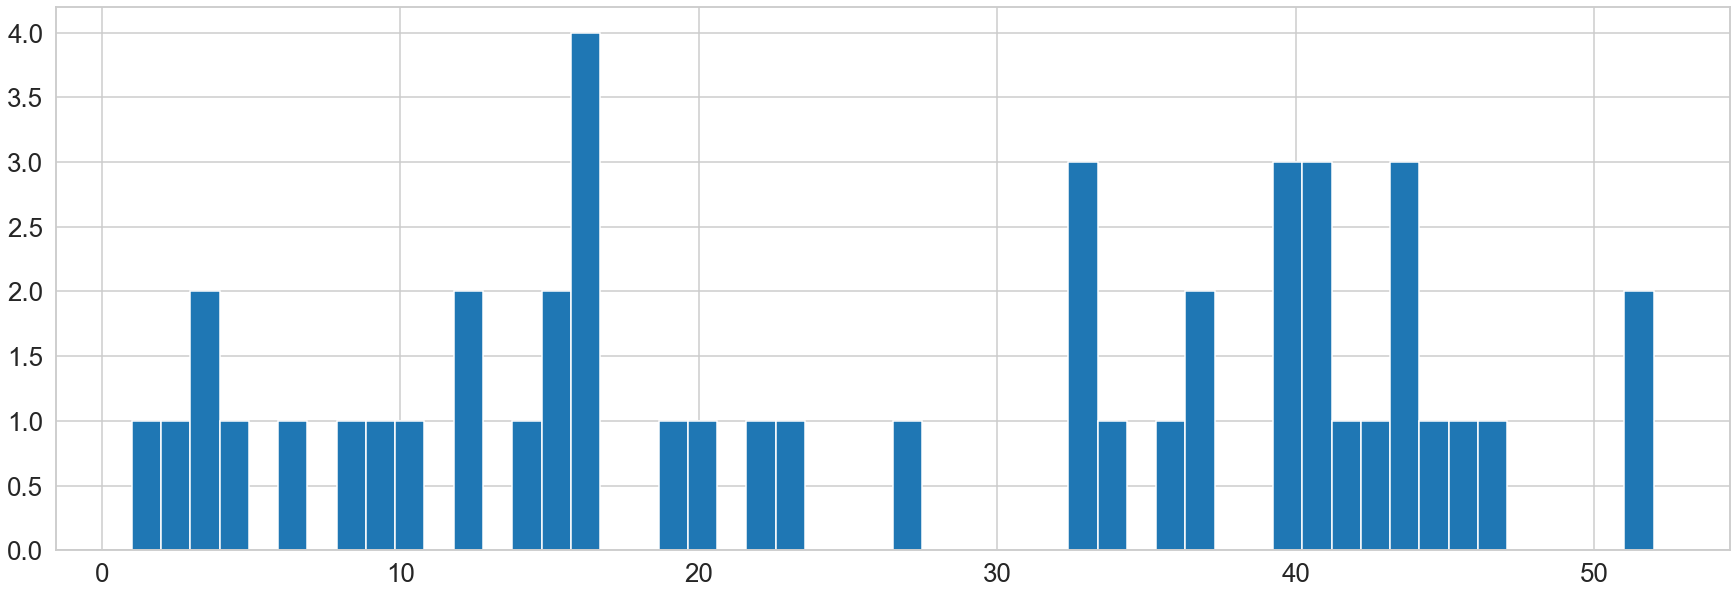

In [23]:
holidays['week_of_year'] = holidays['date'].dt.isocalendar().week
holidays['week_of_year'].hist(bins=52)

### Part 4 - Merge the data

Now that you have a better feel for each of your two (or three, for the 7394 students) data sets, it is time to merge them. Describe your strategy for merging the data sets and then actually perform the merge.  

Develop a strategy for verifying that the data is properly merged (hoping and finger-crossing are not valid strategies). 

#### Merging Strategy
Our strategy to merge Holidays into the dataset is to run the dataset through a few function to return actual meaningful data. By taking the date of the flight and then finding the holiday closest to it, we can find the amount of days until the nearesest holiday. Our belief is that flights that are close to a holiday would be more expensive than those that are farther away. 

To further gain information from the holidays dataset, we can apply functions that find the days to the nearest holiday that is recognized nationally as well as what that holiday is. Certain national holidays, such as Christmas, will most likely influence flight prices so it is important to add to the dataframe

In [24]:
from datetime import date, timedelta, datetime

nationalHolidays = holidays.loc[holidays['holiday_type'] == 1]

def nearestNational(flight):
    min = 365
    for date in nationalHolidays['date']:
        x = abs((flight - date).days)
        if(min > x):
            min = x
    return min

def closestNational(flight):
    i = 0
    min = 365
    holiday = "temp"
    for date in nationalHolidays['date']:
        x = abs((flight - date).days)
        if(min > x):
            min = x
            holiday = nationalHolidays['holiday'].iloc[i]
        i += 1
    return holiday

def nearestHoliday(flight):
    min = 365
    for date in holidays['date']:
        x = abs((flight - date).days)
        if(min > x):
            min = x
    return min

In [25]:
airfare['daysToHoliday'] = airfare['date'].apply(nearestHoliday)
airfare['daysToNationalHoliday'] = airfare['date'].apply(nearestNational)
airfare['NationalHoliday'] = airfare['date'].apply(closestNational)

In [26]:
airfare.head()

,airline,date,starting_city,destination,depart_time,duration,total_stops,price,month,day_of_week,daysToHoliday,daysToNationalHoliday,NationalHoliday
0,IndiGo,2019-03-24,Banglore,New Delhi,22,170.0,0.0,3898,March,Sunday,3,20,Maha Shivaratri (G)
1,Air India,2019-01-05,Kolkata,Banglore,5,445.0,2.0,7663,January,Saturday,4,21,Republic Day (G)
2,Jet Airways,2019-09-06,Delhi,Cochin,9,1140.0,2.0,13883,September,Friday,4,4,Muharram (G)
3,IndiGo,2019-12-05,Kolkata,Banglore,18,325.0,1.0,6219,December,Thursday,11,20,Christmas Day (G)
4,IndiGo,2019-01-03,Banglore,New Delhi,16,285.0,1.0,13303,January,Thursday,2,23,Republic Day (G)


### Part 5 - Explore Bivariate relationships

- Choose a reasoned set of variables to explore further.  You don't have to explore all possible pairs of variables, nor do we want to grade that much.  Choose 7 - 9 variables. One should be a variable that you'd like to predict (target variable) using the others (predictor variables). 
- List your predictor variables
- List your target variable
- Briefly describe why you have chosen these. 

Use any of the available visualizations from Seaborn to explore the relationships between the variables. Explore the relationships among the predictor variables as well as the relationship between each predictor variable and the target variable.  Which of the predictor variables are most strongly related?  Are there any interesting relationships between categorical predictors and numeric predictors?  If there are any dichotomous variables, does that influence any of the relationships? Are the relationships positive or negative? 

Below each plot, you should provide a description and interpretation of the plot.  Make sure to include why the variables in that plot were chosen and what you hope the reader would gain from it as well. 

### Variables
The target variable is price, which we would aim to predict.

To do so we would use:
-Duration 
-Days to nearest holiday 
-Days to the nearest national holiday 
-Closest national holiday
-Airline
-Departure Time
-Total stops

Our reasoning for choosing these variables, is that in our own expirience, similar factors seem to impact price. Longer flights usually cost more. Flying near holidays means increased air traffic and thus higher prices. Certain holidays, like Christmas, usually make flights more expensive. Some airlines cost more than other. The time a flight takes off also usually impacts price, with buisness hours being the most expensive while early morning ones are cheaper.

<AxesSubplot:xlabel='duration', ylabel='price'>

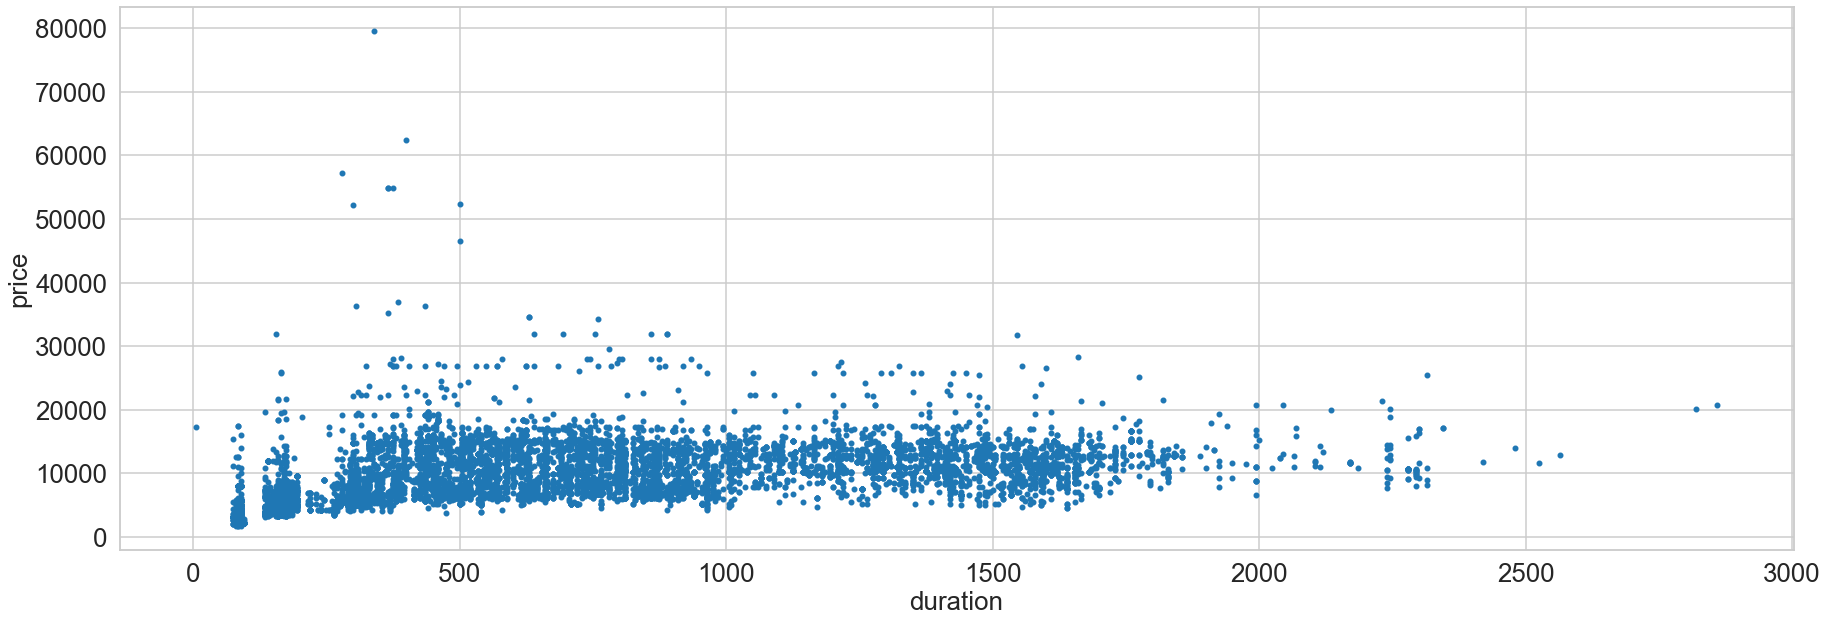

In [27]:
airfare.plot.scatter(x='duration', y='price')

This plot is a simple scatter plot between duration and price. Interestingly, we can see that there is not a very strong correlation between the two variables as one might expect. While the minumim cost increases for longer duration flights at first, it flattens for anything after 500 minutes. 

As a side note, the duration of the flights seems extremely long. One possible explanation is that it also incorporates all delays and layovers between flights, thus explaining how so many can take over 16 hours (1000 min).

<AxesSubplot:xlabel='total_stops', ylabel='duration'>

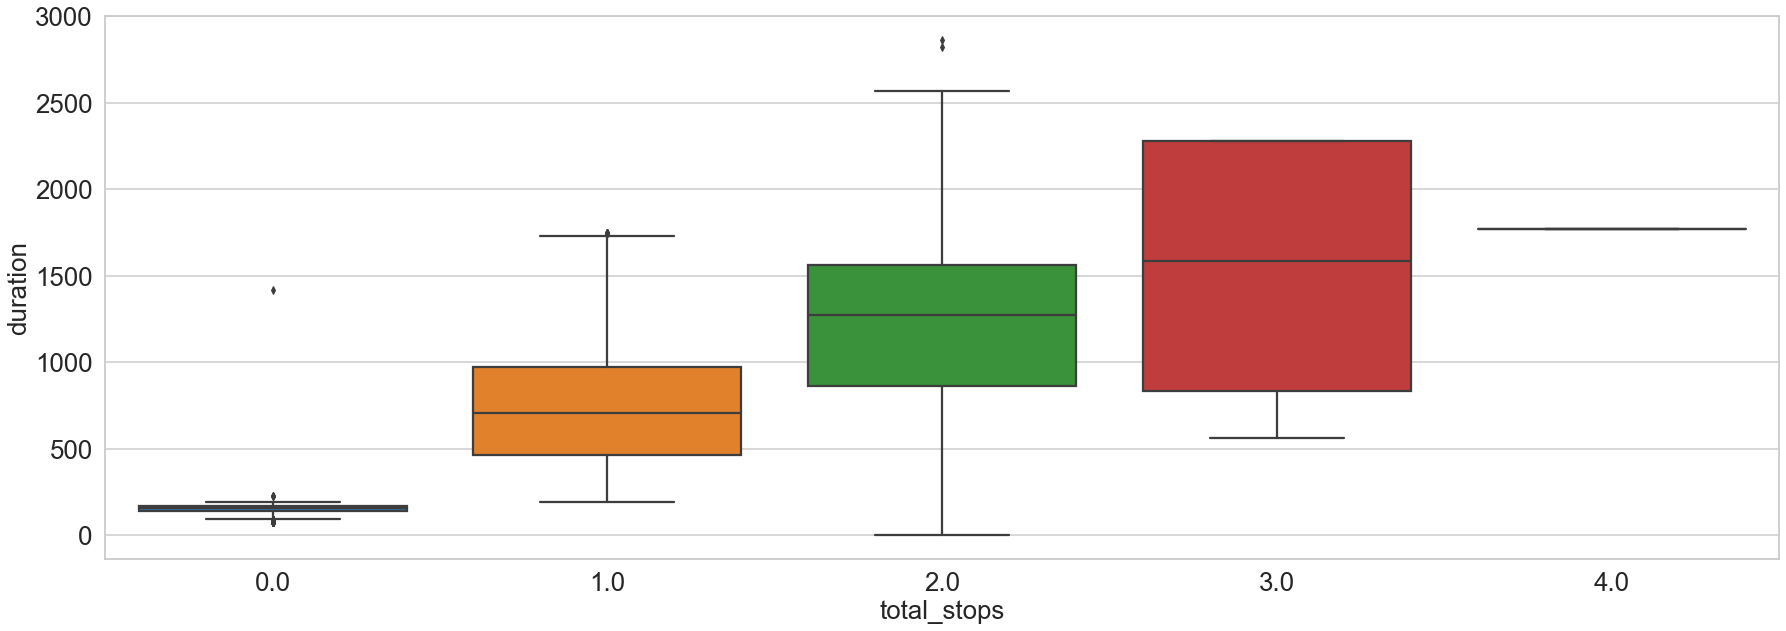

In [28]:
sn.boxplot(x='total_stops', y='duration',data=airfare)

This boxplot confirms that there is a strong correlation between stops and duration of travel. How there are so many itineraries that last over 16 hours, however, is still odd sounding. India really needs to work on that.

<AxesSubplot:xlabel='daysToHoliday', ylabel='price'>

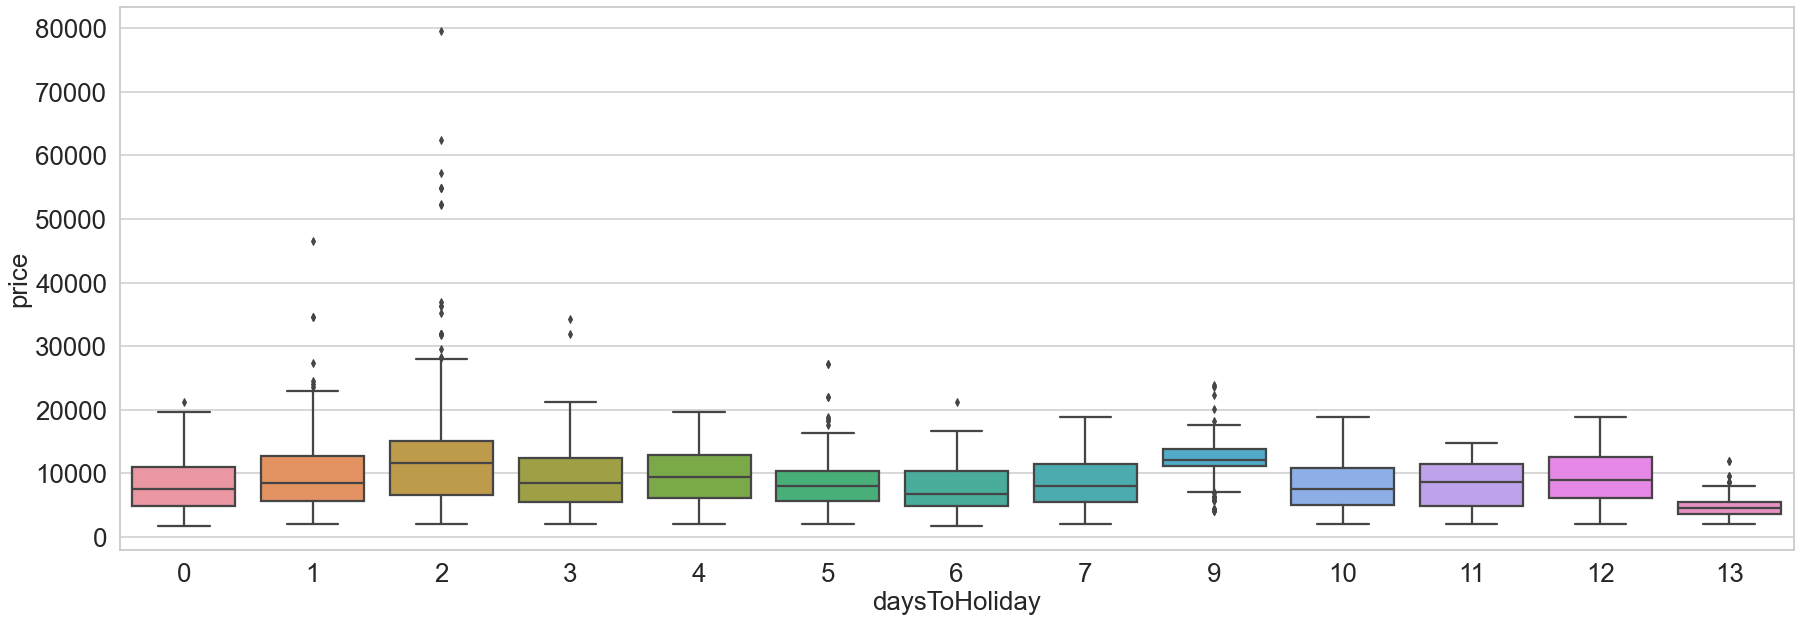

In [29]:
plt.xticks(rotation=0)
sn.boxplot(x='daysToHoliday', y='price',data=airfare)

Here we can see the relationship between days to any nearest holiday and price. While we again expected a stronger correlation, we can see thet there is actually nothing too significant about flying near a holiday opposed to not. The only noticable exception is flights within 3 days of a holiday, as it seems that there are  are more expensive options around that time frame.

<AxesSubplot:xlabel='daysToNationalHoliday', ylabel='price'>

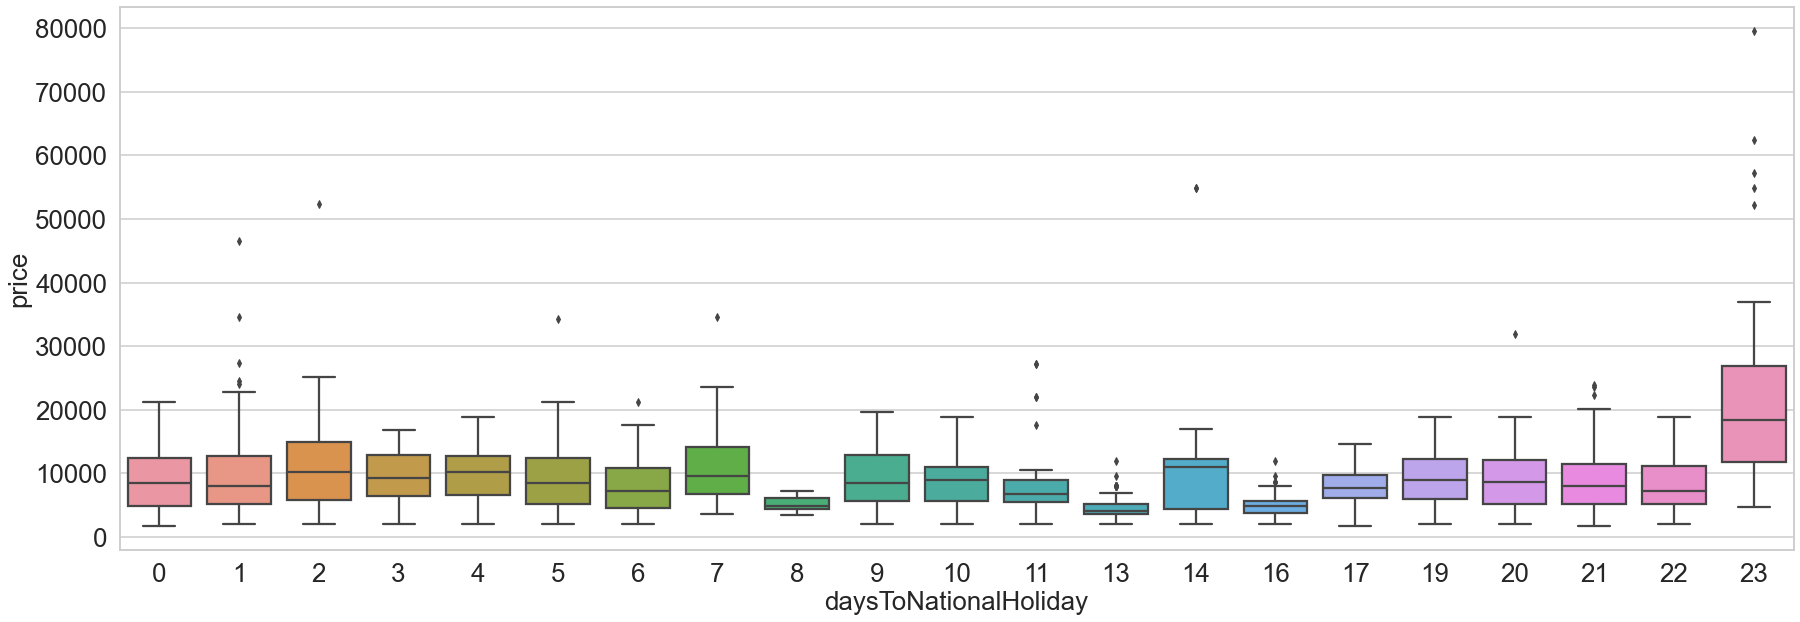

In [30]:
sn.boxplot(x='daysToNationalHoliday', y='price',data=airfare)

In this plot, we explore the same thing as the last plot only the holidays only indlude those which are nationally recognized. And once more, we are suprised to see no strong relationship presenting itself. The only notable thing is that flights 23 days away from a national holiday are oddly expensive. 

<AxesSubplot:xlabel='NationalHoliday', ylabel='duration'>

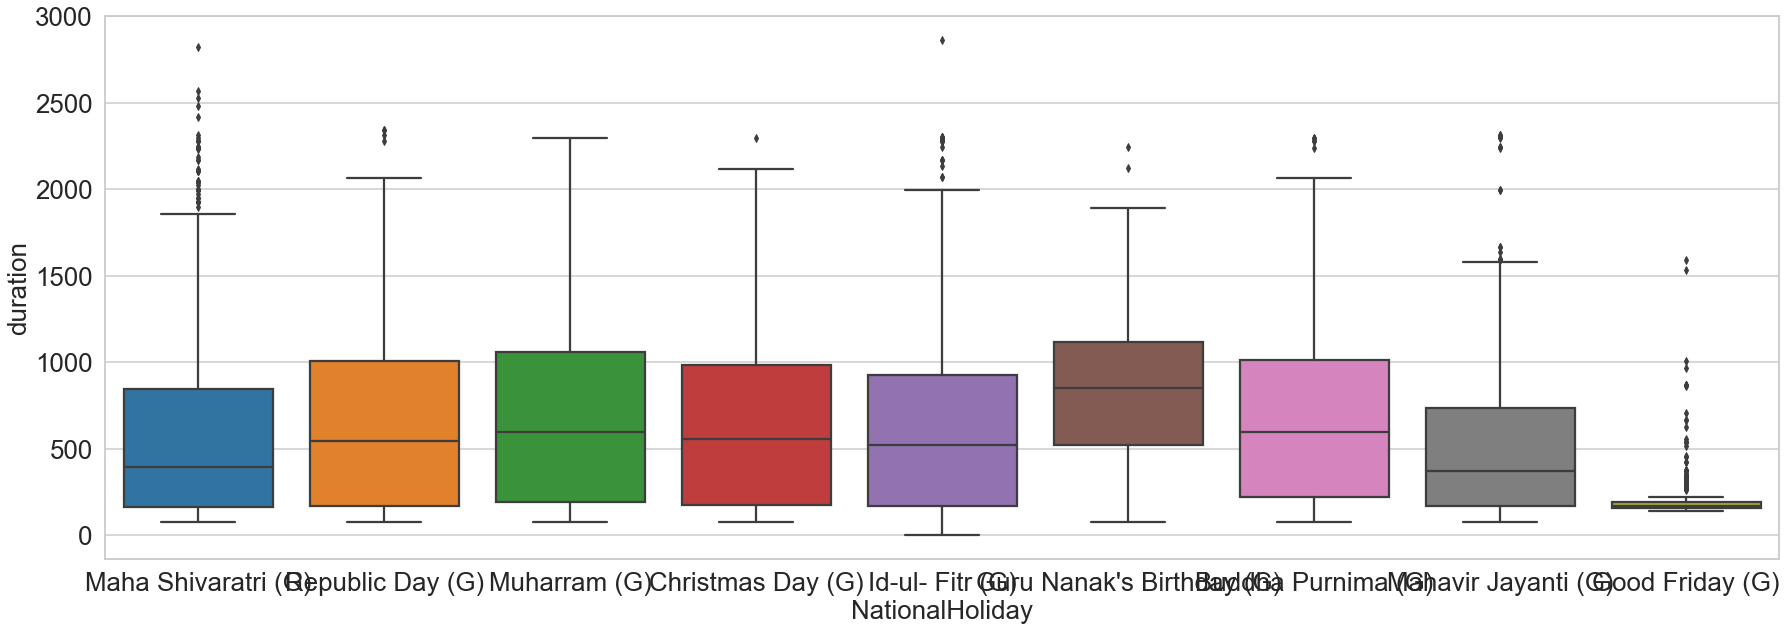

In [31]:
sn.boxplot(x='NationalHoliday', y='duration',data=airfare)

We aimed to see if certain holidays would warrant longer travel durrations, like traveling over Christmas does in America. However, there appears to be a pretty uniformaly distributed duration throughout all the national holidays.

<AxesSubplot:xlabel='NationalHoliday', ylabel='price'>

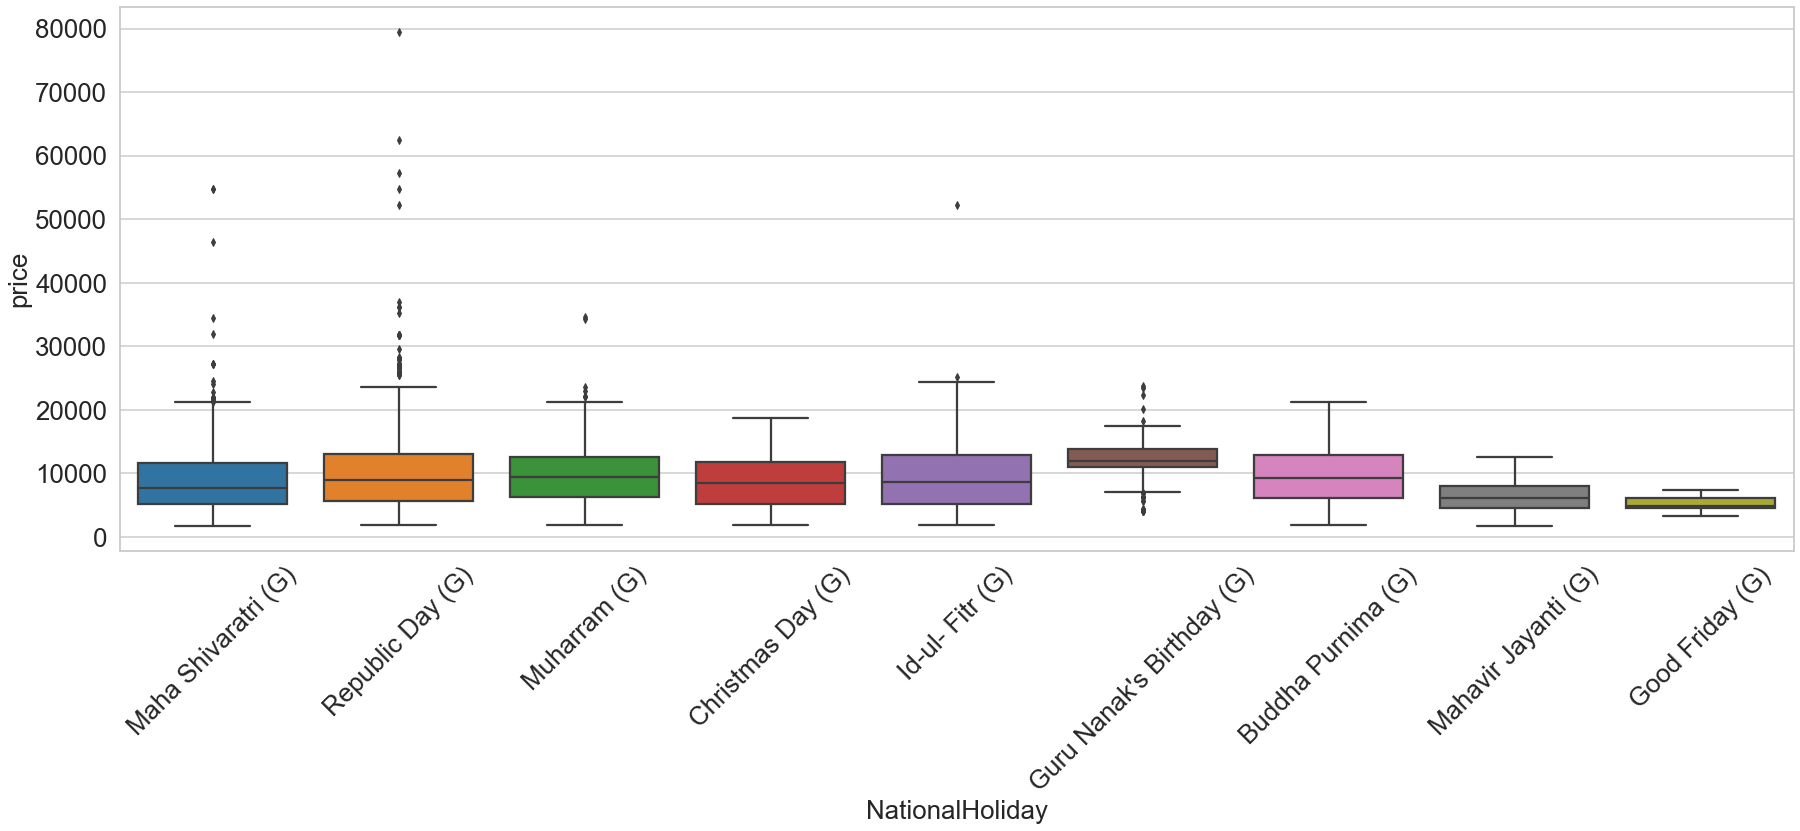

In [32]:
plt.xticks(rotation=45)
sn.boxplot(x='NationalHoliday', y='price',data=airfare)

<AxesSubplot:xlabel='day_of_week', ylabel='price'>

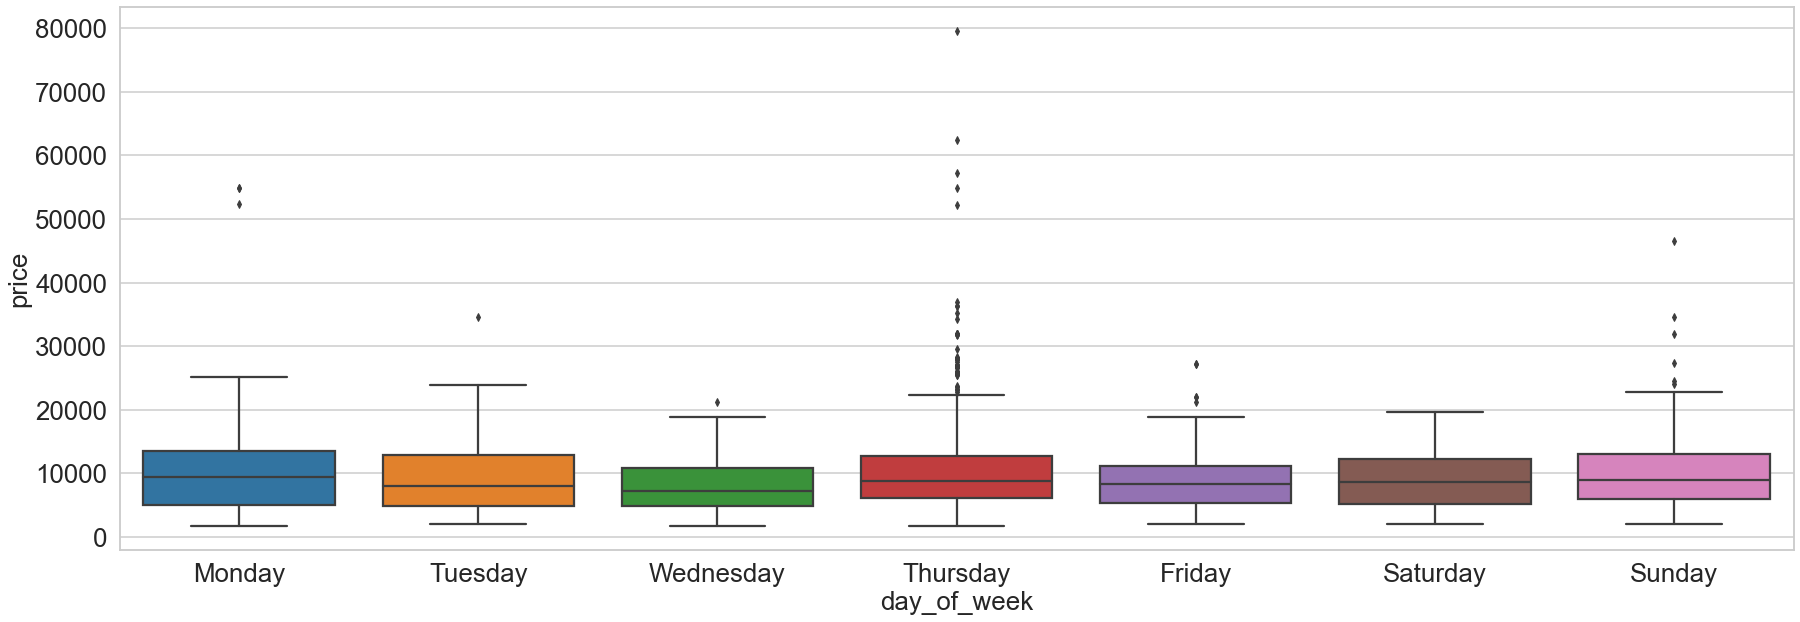

In [33]:
plt.xticks(rotation=0)
sn.boxplot(x='day_of_week', y='price',data=airfare)

In this boxplot, we attempt to find a relationship between the day of the week that the flight is on and its price. While the IQRs are all similar once more, Thursdays seem to offer much more expensive flights than the other days. Considering that Republic Day had a similar distribution of outliers, we would guess that Republic day occured on a Thursday. After looking at the holiday dataset however, we find it is actually on a Saturday. 

<AxesSubplot:xlabel='airline', ylabel='price'>

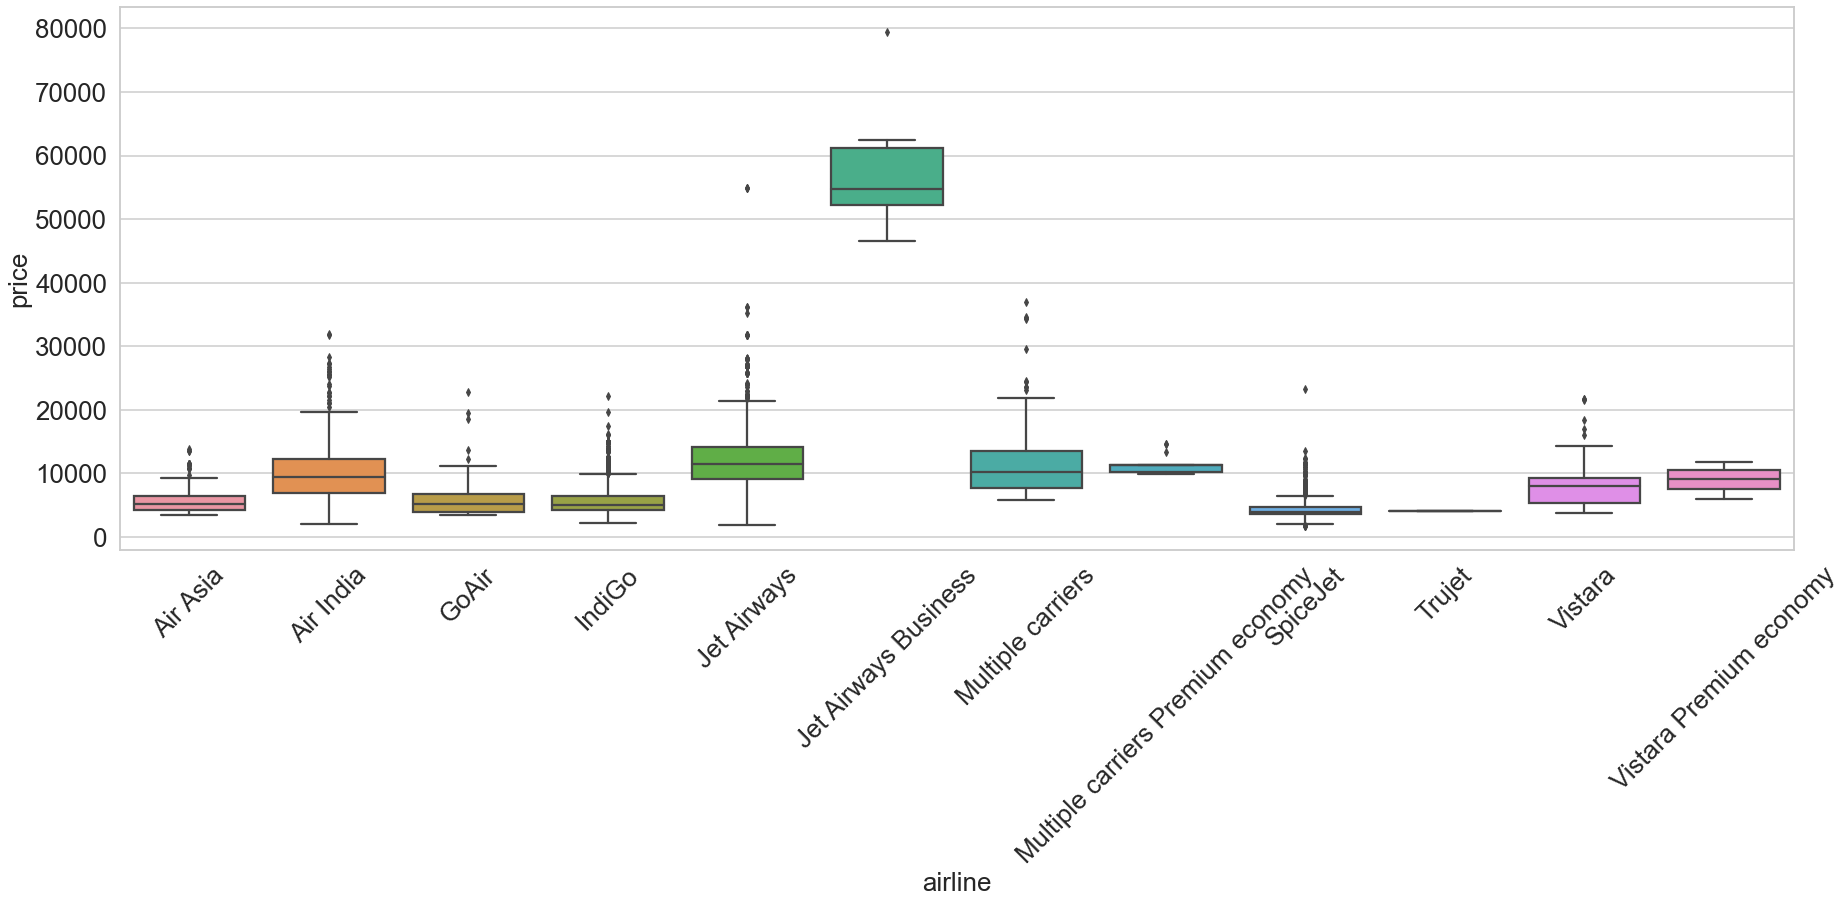

In [34]:
plt.xticks(rotation=45)
sn.boxplot(x='airline', y='price',data=airfare)

Here we can finally see a clear distinction between different airline groups and prices. It appears that each different company has a spefific range and IQR in regards to price of their flights. This data would definitely help when predicting price given all other information. 

<AxesSubplot:xlabel='depart_time', ylabel='price'>

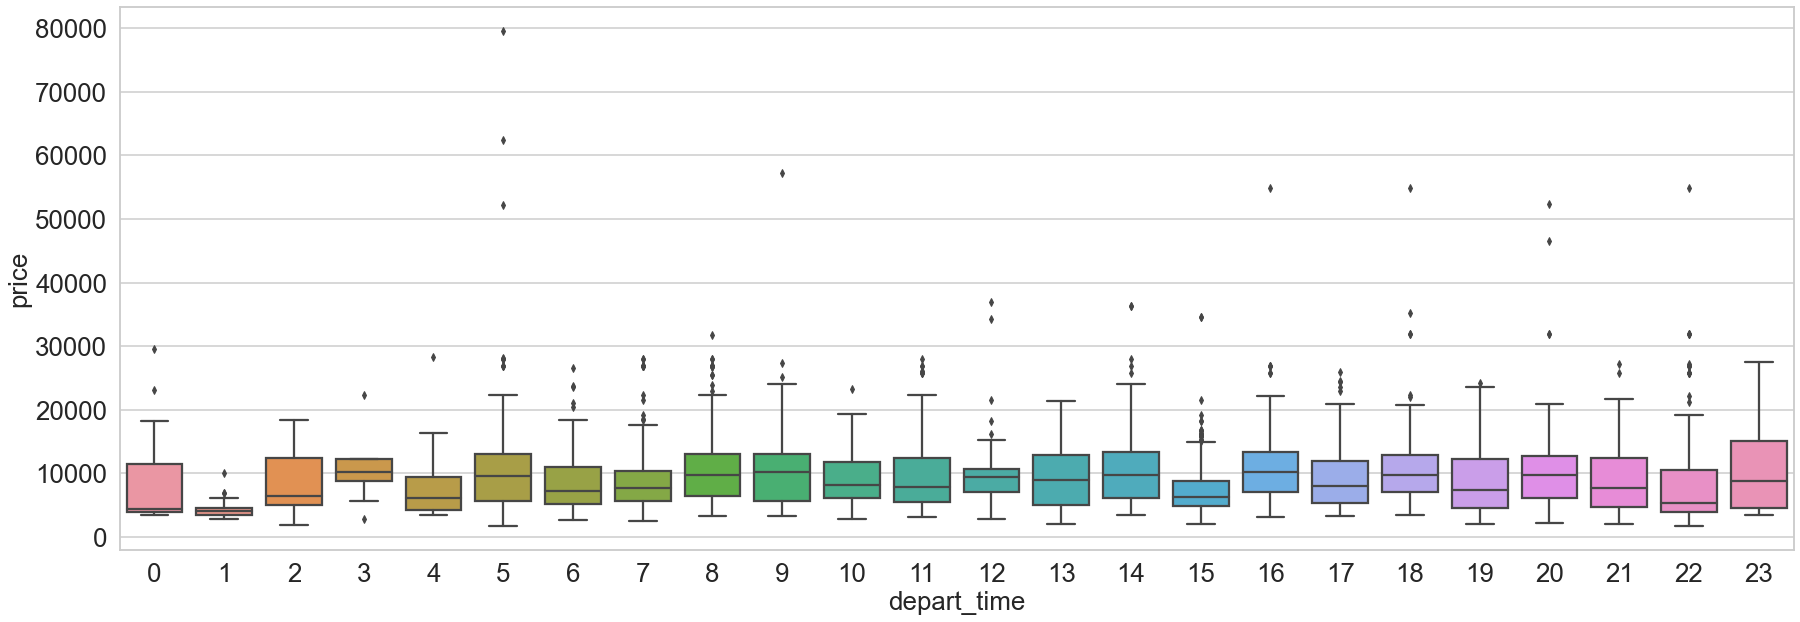

In [35]:
sn.boxplot(x='depart_time', y='price',data=airfare)

For our last exploration, we compare the departure time (to closest hour) to it's price. We can see a few patterns here. As one would expect, it seems that the few flights that are offered at 1 in the morning are cheaper compared to everthing else. While the IQR is similar for most other times, those that are during normal business hours (9-16) have a higher range compared to flights earlier or later. With this, we could expect that when given when a